In [1]:
# Imports
import torch
from torch.distributions import Normal,Uniform,Gamma,Laplace,OneHotCategorical
import os
import time
from functools import partial

from causal_cocycle.model import cocycle_model,flow_model,cocycle_outcome_model
from causal_cocycle.optimise import *
from causal_cocycle.loss_functions import Loss
from causal_cocycle.conditioners import Empty_Conditioner,Constant_Conditioner,Lin_Conditioner,NN_RELU_Conditioner
from causal_cocycle.transformers import Transformer,Shift_layer,Scale_layer,RQS_layer,Inverse_layer
from causal_cocycle.helper_functions import likelihood_loss,mmd,propensity_score
from causal_cocycle.kernels import *
from causal_cocycle.kde import *

#Shorthand function calls
def NN(i,o=2,width=128,layers=2):
    return NN_RELU_Conditioner(width = width,
                                     layers = layers, 
                                     input_dims =  i, 
                                     output_dims = o,
                                     bias = True)

T = partial(Transformer,logdet = True)

In [2]:
# DGP functions
def cdf(X,t):
    return ((X<= t.T)*1).float().mean(0)

class IG:
    
    def __init__(self,alpha,beta):
        self.alpha = alpha
        self.beta = beta
        
    def sample(self,size):
        return 1/Gamma(self.alpha,self.beta).sample(size)

class Mixture1D:
    
    def __init__(self,base_dists,probabilities,noints,scales):
        self.dists = base_dists
        self.probabilities = probabilities
        self.noints = noints
        self.scales = scales
        
    def sample(self,size):
        C = OneHotCategorical(probabilities).sample(size)[:,0]
        Z = torch.zeros((size[0],len(probabilities)))
        for i in range(len(self.dists)):
            Z[:,i] = self.noints[i]+self.scales[i]*self.dists[i].sample(size).T
        return (Z*C).sum(1)[:,None]          

def policy(V, flip_prob = 0.00):
    Z = (V.mean(1)*len(V.T)**0.5)[:,None]
    X_correct =  (Z<-1)*0+(Z>=-1)*(Z<1)*1 + (Z>=1)*2
    flips = (Uniform(0,1).sample((len(V),1))<flip_prob)*1
    return X_correct*(1-flips) + torch.randint(3, (len(V),1))*flips

def new_policy(V, flip_prob = 0.00):
    Z = (V.mean(1)*len(V.T)**0.5)[:,None]
    X_correct =  (Z<-1)*0+(Z>=-1)*1
    flips = (Uniform(0,1).sample((len(V),1))<flip_prob)*1
    return X_correct*(1-flips) + torch.randint(2, (len(V),1))*flips

def shift(V,policy,coeffs):
    t = policy(V)
    z = V @ coeffs
    return 1/(1+torch.exp(z)) + ((t==0)*torch.exp(-0.1*(z+3)**2) + 
                                 (t==1)*torch.exp(-0.1*(z-0)**2)*0.75 + 
                                 (t==2)*torch.exp(-0.1*(z-3)**2)*0.5)

def scale(V,coeffs):
    z = V @ coeffs
    return 0.1*(torch.exp(-1/10*(z+2)**2*(z-2)**2)+1)

def DGP(N,D,policy,covariate_corr = 0, 
        covariate_dist = Normal(0,1),
        noise_dist = Normal(0,1)):
    Sigma = (1-covariate_corr)*torch.eye(D)+covariate_corr*torch.ones((D,D))
    A = torch.linalg.cholesky(Sigma)
    Z = covariate_dist.sample((N,D)) @ A.T
    U = noise_dist.sample((N,1))
    Y = shift(Z,policy,coeffs) + scale(Z,coeffs)*U
    X = torch.column_stack((policy(Z),Z))
    return Z,X,Y

In [3]:
# DGP set up
N = 10**4
D = 10
Zcorr = 0.0
flip_prob = 0.05
coeffs = 1/torch.linspace(1,D,D)[:,None]**1
coeffs *= 1/coeffs.sum()
means = torch.tensor([[-2, 0]]).T # means for mixture U dist
scales = torch.tensor([[-1.0, 1.0]]).T  # variances for mixture U dist
probabilities = torch.tensor([1/2,1/2]) # mixture probs for mixture U dist
base_dists = [IG(10,10),IG(1,1)]
noise_dist = Mixture1D(base_dists,probabilities,means,scales)
Zdist = Normal(0,1.5)

In [4]:
# Method + opt set up
cocycle_loss = "CMMD_V"
batch_size = 64
validation_method = "fixed"
layers = 2
width = 128
train_val_split = 0.5
learn_rate = [1e-3]
scheduler = False
maxiter = 10000
miniter = 10000
weight_decay = 1e-3
RQS_bins = 8

In [5]:
# Setting training optimiser args
opt_args = ["learn_rate",
            "scheduler",
            "batch_size",
            "maxiter",
            "miniter",
            "weight_decay",
            "print_"]
opt_argvals = [learn_rate,
              scheduler,
              batch_size,
             maxiter,
              miniter,
              weight_decay,
              True]

In [7]:
# Specifying models for cross-validation

# Specifying list of hypers to construct models from
hypers = ["weight_decay"]
hypers_list = [[1e-3]]
conditioners_list = [[NN(D+1,1,width,layers),NN(D+1,1,width,layers)]]#[#[NN(D+1,1,width,layers)],
                          #[NN(D+1,1,width,layers),NN(D+1,1,width,layers),NN(D+1,3*RQS_bins + 2,width,layers)]]
transformers_list = [Transformer([Shift_layer(),Scale_layer()])]#[#Transformer([Shift_layer()]),
                           #Transformer([Shift_layer(),Scale_layer(),RQS_layer(RQS_bins)])

# Constructing all model combinations
models_validation = []
hyper_argvals = []
for m in range(len(conditioners_list)):
    for hyper in hypers_list:
        for hyper_value in hyper:
            models_validation.append(cocycle_model(conditioners_list[m],transformers_list[m]))
            hyper_argvals.append([hyper_value])
hyper_args = [hypers]*len(hyper_argvals)

In [11]:
hyper_args, hyper_argvals

([['weight_decay']], [[0.001]])

In [8]:
# DGP
ntrain = int(train_val_split*N)
Z,X,Y = DGP(N,D,partial(policy,flip_prob = flip_prob),Zcorr,Zdist,noise_dist)
Ztrain,Xtrain,Ytrain = Z[:ntrain],X[:ntrain],Y[:ntrain]
Ztest,Xtest,Ytest = Z[ntrain:],X[ntrain:],Y[ntrain:]

In [12]:
# Getting loss functon and training model
loss_fn =  Loss(loss_fn = cocycle_loss,
                            kernel = [gaussian_kernel(torch.ones(1),1)]*2)
loss_fn.median_heuristic(X,Y,subsamples = 10**4)                        
models_validation,val_losses = validate(models_validation,
                                         loss_fn,
                                         X,
                                         Y,
                                         loss_fn,
                                         validation_method,
                                         train_val_split,
                                         opt_args,
                                         opt_argvals,
                                         hyper_args,
                                         hyper_argvals)
best_ind = torch.where(val_losses ==val_losses.min())[0][0]
final_model = models_validation[best_ind]

Training loss last 10 avg is : tensor(-0.6008)
99.9  % completion
Finished optimising final model


TypeError: 'cocycle_model' object is not subscriptable

# Debug

In [16]:
# Extract predicted functions and true functions
shift_pred = models_validation.conditioner[0]
scale_pred = models_validation.conditioner[1]
from BD import shift, scale

In [20]:
# Get test points
from torch.distributions import Normal
ntest = 1000
Ztest = Normal(0,1.5).sample((1000, D))
Xtest = torch.column_stack((policy(Ztest),Ztest))

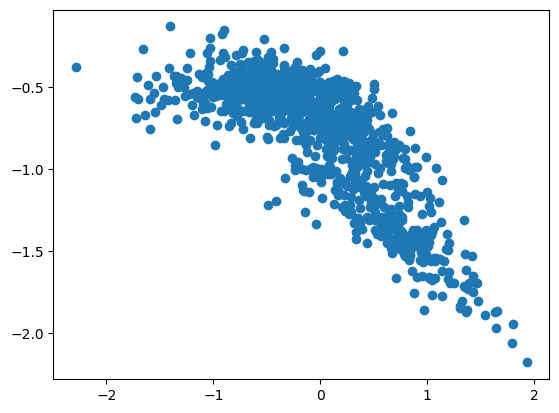

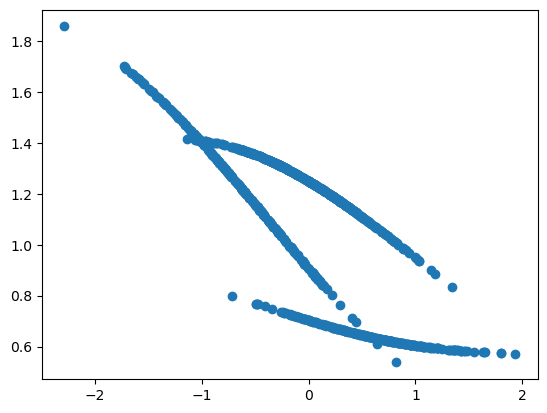

In [22]:
coeffs = 1 / torch.linspace(1, D, D)[:, None] ** 1
coeffs *= 1 / coeffs.sum()
plt.scatter(Ztest @ coeffs , shift_pred(Xtest).detach())
plt.show()
plt.scatter(Ztest @ coeffs, shift(Ztest,policy, coeffs).detach())

In [9]:
# Defining outcome model and feature of interest (i.e. cdf)
feature = lambda x,t: (torch.sigmoid(x)[None]<= t[...,None]).float()
conditional_mean_model = cocycle_outcome_model(final_model,Xtrain,Ytrain)

In [208]:
# Sampling from interventional distribution
ntest = 5000
nintsample = ntest
Zintdist = Normal(1,1.5)
Zshift,Xshift,Yshift = DGP(nintsample,D,partial(policy),Zcorr,Zintdist,noise_dist)
Zint,Xint,Yint = DGP(nintsample,D,partial(new_policy),Zcorr,Zintdist,noise_dist)
Zshift_train,Xshift_train = Zshift[:ntest],Xshift[:ntest]
Xint_train = Xint[:ntest]

In [209]:
# cdf values
t = torch.linspace(0,1,1000)[:,None]

# Cocycle model cdf
batch = 100
nbatch = int(len(t)/batch)
cocycle_cdf_int = torch.zeros(len(t))
cocycle_cdf_shift = torch.zeros(len(t))
for i in range(nbatch):
    cocycle_cdf_int[i*batch:(i+1)*batch] = conditional_mean_model(Xint_train,
                                                              partial(feature,t = t[i*batch:(i+1)*batch])).mean(1)
    cocycle_cdf_shift[i*batch:(i+1)*batch] = conditional_mean_model(Xshift_train,
                                                              partial(feature,t = t[i*batch:(i+1)*batch])).mean(1)
    
    print("getting cdf value batch ",i+1,"/",nbatch)

# True cdf
true_cdf_int = feature(Yint,t).mean((1,2))
true_cdf_shift = feature(Yshift,t).mean((1,2))

getting cdf value batch  0 / 10
getting cdf value batch  1 / 10
getting cdf value batch  2 / 10
getting cdf value batch  3 / 10
getting cdf value batch  4 / 10
getting cdf value batch  5 / 10
getting cdf value batch  6 / 10
getting cdf value batch  7 / 10
getting cdf value batch  8 / 10
getting cdf value batch  9 / 10


In [210]:
# Training propensity score models
Propensity_score_model_est = []
Propensity_score_model_policy = []
Propensity_score_model_new_policy = []

# Estimating mistae probabilities
Xtrue = policy(Ztrain)
states = torch.unique(X[:,0]).int()
nstate = len(states)
P = torch.zeros((nstate,nstate))
for i in range(nstate):
    for j in range(nstate):
        P[i,j] = ((Xtrain[:,0]==states[i])*(Xtrue[:,0]==states[j])).float().sum()
P *= 1/P.sum(0)

propensity_model_est = propensity_score(P,policy)
propensity_model_new_policy = propensity_score(torch.eye(len(P)),new_policy)  
propensity_model_policy = propensity_score(torch.eye(len(P)),policy)  

In [246]:
# Training density models
kde_learn_rate = 0.1
kde_miniter = 100
kde_maxiter = 100
kde_tol = 1e-2
kde_nfold = 3
kde_reg = 1e-6

Densities_Z = []
Densities_Z_shift = []
    
    
kernel = inverse_gaussian_kernel(lengthscale = torch.ones(D),scale = 1.0)
density_z = KDE(kernel)
losses = density_z.optimise(Ztrain,kde_learn_rate,kde_miniter,kde_maxiter,kde_tol,kde_nfold,kde_reg)

density_zshift = density_z
#kernel_shift = inverse_gaussian_kernel(lengthscale = torch.ones(D),scale = 1.0)
#density_zshift = KDE(kernel_shift)
#losses_shift = density_zshift.optimise(Zshift_train,kde_learn_rate,kde_miniter,kde_maxiter,kde_tol,kde_nfold,kde_reg)

iter 0 , loss =  tensor(68974.1719)
iter 10 , loss =  tensor(68908.6953)
iter 20 , loss =  tensor(68895.2344)
iter 30 , loss =  tensor(68888.7500)
iter 40 , loss =  tensor(68887.5469)
iter 50 , loss =  tensor(68887.1875)
iter 60 , loss =  tensor(68887.1250)
iter 70 , loss =  tensor(68887.1172)
iter 80 , loss =  tensor(68887.0781)
iter 90 , loss =  tensor(68887.0703)
iter 0 , loss =  tensor(68977.1484)
iter 10 , loss =  tensor(68913.4375)
iter 20 , loss =  tensor(68903.6719)
iter 30 , loss =  tensor(68899.2344)
iter 40 , loss =  tensor(68897.8750)
iter 50 , loss =  tensor(68897.6406)
iter 60 , loss =  tensor(68897.5781)
iter 70 , loss =  tensor(68897.5625)
iter 80 , loss =  tensor(68897.5469)
iter 90 , loss =  tensor(68897.5469)


In [265]:
# True densities
class normal:

    def __init__(self,mu,sigma2):
        self.mu = mu
        self.var = sigma2

    def forward(self,data,X):
        return Normal(self.mu,self.var).log_prob(data).sum(1).exp()

density_zshift = normal(1,1.5)
density_z = normal(0,1.5)

In [266]:
len(weights_int)/weights_int.sum()

tensor(1.0000)

In [267]:
# Getting IPW estimator
weights_shift = ((propensity_model_policy(Xtest,Ztest)*
                density_zshift.forward(Ztest,Zshift_train))/
                (propensity_model_est(Xtest,Ztest)*
                density_z.forward(Ztest,Ztrain))).detach()

weights_int = ((propensity_model_new_policy(Xtest,Ztest)*
                density_zshift.forward(Ztest,Zshift_train))/
                (propensity_model_est(Xtest,Ztest)*
                density_z.forward(Ztest,Ztrain))).detach()

weights_shift *= len(weights_shift)/weights_shift.sum()
weights_int *= len(weights_shift)/weights_int.sum()

IPW_cdf_shift = (weights_shift[None,:,None]*feature(Ytest,t)).mean((1,2))
IPW_cdf_int = (weights_int[None,:,None]*feature(Ytest,t)).mean((1,2))

In [268]:
# Getting DR estimator (start by adding on IPW term to outcome model
cocycle_DR_cdf_shift = cocycle_cdf_shift + IPW_cdf_shift
cocycle_DR_cdf_int = cocycle_cdf_int + IPW_cdf_int

for i in range(nbatch):
    # Getting batch of conditional means and propensity weights
    conditional_mean_batch = conditional_mean_model(Xtest,partial(feature,t = t[i*batch:(i+1)*batch]))

    # Updating DR estimator
    cocycle_DR_cdf_shift[i*batch:(i+1)*batch] -= (weights_shift*conditional_mean_batch).mean(1)
    cocycle_DR_cdf_int[i*batch:(i+1)*batch] -= (weights_int*conditional_mean_batch).mean(1)

    print("getting cdf value batch ",i+1,"/",nbatch)   

getting cdf value batch  0 / 10
getting cdf value batch  1 / 10
getting cdf value batch  2 / 10
getting cdf value batch  3 / 10
getting cdf value batch  4 / 10
getting cdf value batch  5 / 10
getting cdf value batch  6 / 10
getting cdf value batch  7 / 10
getting cdf value batch  8 / 10
getting cdf value batch  9 / 10


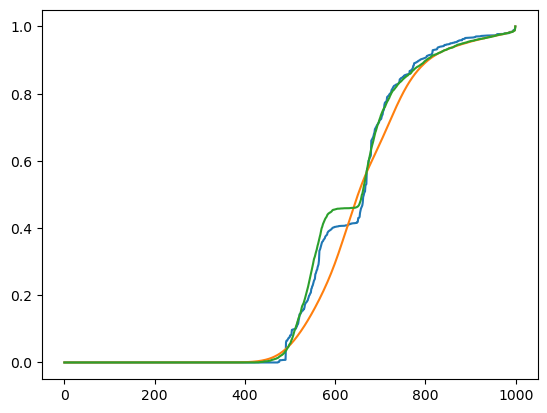

In [269]:
plt.plot(IPW_cdf_shift)
plt.plot(cocycle_cdf_shift)
plt.plot(true_cdf_shift)

In [271]:
print((cocycle_cdf_shift -true_cdf_shift).abs().mean())
print((cocycle_DR_cdf_shift -true_cdf_shift).abs().mean())

print((cocycle_cdf_int -true_cdf_int).abs().mean())
print((cocycle_DR_cdf_int -true_cdf_int).abs().mean())

tensor(0.0226)
tensor(0.0111)
tensor(0.0249)
tensor(0.0469)
